I am predicting which employees are the most likely to change jobs, explore why, (and come up with recommendations what employers should do to keep staff - I will add this to the next update).

In [1]:
# Import the modules

import pandas as pd
import numpy as np
from scipy import stats
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec
import seaborn as sns
#from statsmodels.graphics.mosaicplot import mosaic
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import svm
import xgboost as xgb
#from mlxtend.classifier import StackingClassifier #need to install manually

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split # why? the data is already split into test and train
from sklearn.model_selection import GridSearchCV

sns.set(style='white', context='notebook', palette='deep') #maybe undo style

#in addition, add modules from iris
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier


In [2]:
#Load data
data = pd.read_csv('C:/Users/akosciansky/Desktop/Kaggle/Human_Resources/HR_comma_sep.csv')

# Data Inspection

The first step is to check for missing values in the data set. That's import so that we can put the summary statistics in context. Missing data can lead to a false impression of the data distribution and we need to be aware of that.

In [3]:
print(data.isnull().sum())

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64


We got lucky and there are no missing data, which is usually not the case.

Next, let's check with what kind of variables we are dealing with, i.e. are the variables categorical, numerical etc.? 

In [4]:
data.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

So, **satisfaction_level** and **last_evaluation** are continuous numerical data but we need to confirm that. They could be misclassified and should really be integers. 

**sales** and **salary** are strings and probably categorical.

The other variables are integers but it is not quite clear whether they are numerical or really categorical data.

Let's look at the first few lines of the dataset to get a fell for what the data looks like.

In [5]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


And now let's look at a brief summary of the data. The describe function only works on numerical data unfortunately. We will get to a summary of categorical variables shortly though.

In [6]:
data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


And now let's look at this visually

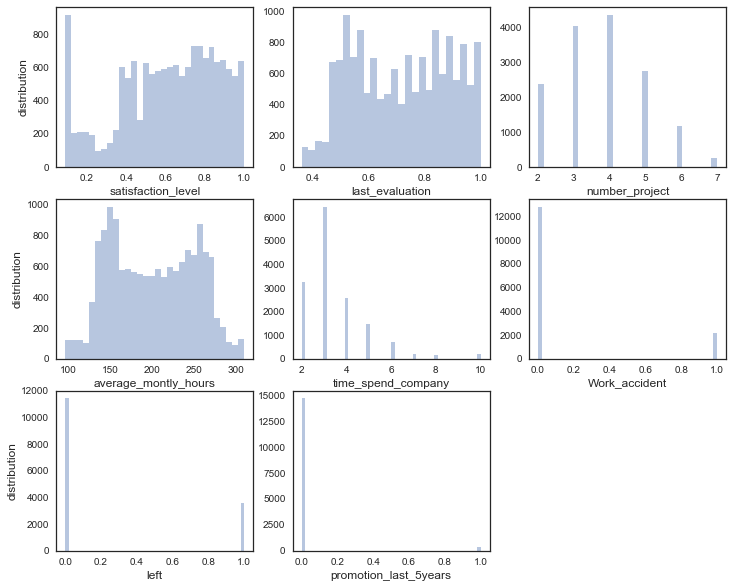

In [7]:
 #histograms
warnings.filterwarnings('ignore')
plt.figure(figsize=[12,10])

plt.subplot(331)
plt.xlabel('satisfaction_level', fontsize=12)
plt.ylabel('distribution', fontsize=12)
sns.distplot(data['satisfaction_level'], kde=False)

plt.subplot(332)
plt.xlabel('last_evaluation', fontsize=12)
#plt.ylabel('distribution', fontsize=12)
sns.distplot(data['last_evaluation'], kde=False)

plt.subplot(333)
plt.xlabel('number_project', fontsize=12)
#plt.ylabel('distribution', fontsize=12)
sns.distplot(data['number_project'], kde=False)

plt.subplot(334)
plt.xlabel('average_montly_hours', fontsize=12)
plt.ylabel('distribution', fontsize=12)
sns.distplot(data['average_montly_hours'], kde=False)

plt.subplot(335)
plt.xlabel('time_spend_company', fontsize=12)
#plt.ylabel('distribution', fontsize=12)
sns.distplot(data['time_spend_company'], kde=False)

plt.subplot(336)
plt.xlabel('Work_accident', fontsize=12)
#plt.ylabel('distribution', fontsize=12)
sns.distplot(data['Work_accident'], kde=False)

plt.subplot(337)
plt.xlabel('left', fontsize=12)
plt.ylabel('distribution', fontsize=12)
sns.distplot(data['left'], kde=False)

plt.subplot(338)
plt.xlabel('promotion_last_5years', fontsize=12)
#plt.ylabel('distribution', fontsize=12)
sns.distplot(data['promotion_last_5years'], kde=False)

Now, we have a good idea of the distributions and what kind of data they are. 
**satisfaction_level**, **last_evaluation**, **number_project**, **average_montly_hours**, and **time_spend_company** are numerical variables.
**Work_accident**, **promotion_last_5_years**, and **left** are categorical data where 1 means *yes* and 0 means *no*.
We can also see some interesting bi-modal distribtuion and a very high number satisfaction levels of 0 but more of that in the next section.

Let's move onto the categorical variables we have not looked at yet.

In [8]:
data['sales'].value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: sales, dtype: int64

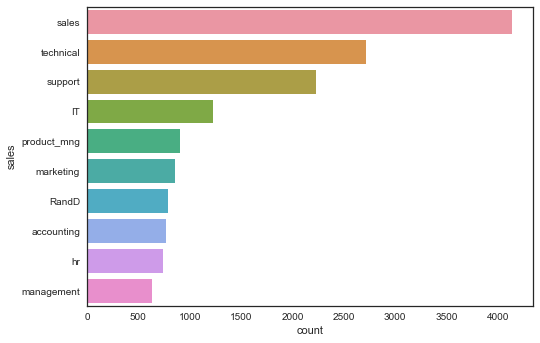

In [9]:
count = data.groupby(data['sales']).count()
count = pd.DataFrame(count.to_records())
count = count.sort_values(by= 'left', ascending = False)
count = count['sales']

sns.countplot(y='sales', data=data, order=count)

In [10]:
data['salary'].value_counts()

low       7316
medium    6446
high      1237
Name: salary, dtype: int64

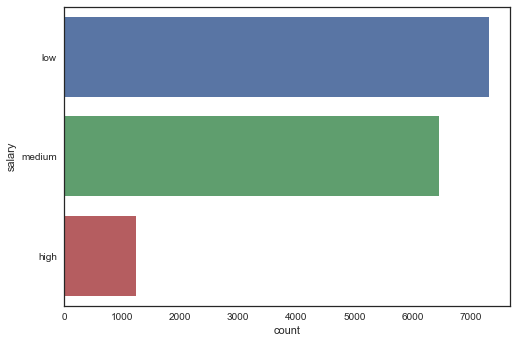

In [11]:
count = data.groupby(data['salary']).count()
count = pd.DataFrame(count.to_records())
count = count.sort_values(by= 'left', ascending = False)
count = count['salary']

sns.countplot(y='salary', data=data, order=count)

# Data Analysis

Let's first start off with calculating the baseline prediction, which is the proportion of leavers out of all employees. We will use this in the next section to compare against the predictive models. For now, it will be useful to check whether there are any types of jobs that are more risk of employees leaving etc. 

In [12]:
#Calculate the baseline prediction accuracy
#colour code left
left = data[data['left']==1]
stayed = data[data['left']==0]
left_col = 'blue'
stayed_col = 'red'

print('Left: %i (%.1f percent), Stayed: %i (%.1f percent), Total: %i'\
     %(len(left), 1.*len(left)/len(data)*100.0,\
      len(stayed), 1.*len(stayed)/len(data)*100.0, len(data)))

Left: 3571 (23.8 percent), Stayed: 11428 (76.2 percent), Total: 14999


Let's compare leavers and stayers and plot them against each other.

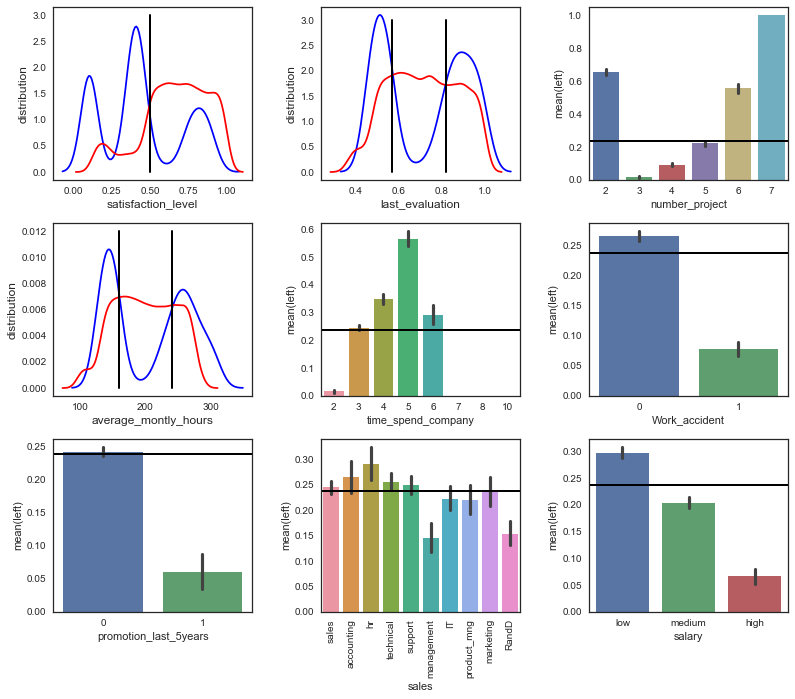

In [13]:
#plot the variables against their survival rates
warnings.filterwarnings('ignore')
plt.figure(figsize=[12,10])

plt.subplot(331)
plt.xlabel('satisfaction_level', fontsize=12)
plt.ylabel('distribution', fontsize=12)
sns.kdeplot(left['satisfaction_level'].dropna().values, color=left_col)
sns.kdeplot(stayed['satisfaction_level'].dropna().values, color=stayed_col)
plt.plot([0.5, 0.5], [3, 0], linewidth=2, color='black')

plt.subplot(332)
plt.xlabel('last_evaluation', fontsize=12)
plt.ylabel('distribution', fontsize=12)
sns.kdeplot(left['last_evaluation'].dropna().values, color=left_col)
sns.kdeplot(stayed['last_evaluation'].dropna().values, color=stayed_col)
plt.plot([0.57, 0.57], [3, 0], linewidth=2, color='black')
plt.plot([0.82, 0.82], [3, 0], linewidth=2, color='black')

plt.subplot(333)
sns.barplot('number_project', 'left', data=data)
plt.plot([-1, 10], [0.238, 0.238], linewidth=2, color='black')

plt.subplot(334)
plt.xlabel('average_montly_hours', fontsize=12)
plt.ylabel('distribution', fontsize=12)
sns.kdeplot(left['average_montly_hours'].dropna().values, color=left_col)
sns.kdeplot(stayed['average_montly_hours'].dropna().values, color=stayed_col)
plt.plot([160, 160], [0.012, 0], linewidth=2, color='black')
plt.plot([240, 240], [0.012, 0], linewidth=2, color='black')

plt.subplot(335)
sns.barplot('time_spend_company', 'left', data=data)
plt.plot([-1, 10], [0.238, 0.238], linewidth=2, color='black')

plt.subplot(336)
sns.barplot('Work_accident', 'left', data=data)
plt.plot([-1, 10], [0.238, 0.238], linewidth=2, color='black')

plt.subplot(337)
sns.barplot('promotion_last_5years', 'left', data=data)
plt.plot([-1, 10], [0.238, 0.238], linewidth=2, color='black')

plt.subplot(338)
sns.barplot('sales', 'left', data=data)
plt.plot([-1, 10], [0.238, 0.238], linewidth=2, color='black')
plt.xticks(rotation=90)

plt.subplot(339)
sns.barplot('salary', 'left', data=data)
plt.plot([-1, 10], [0.238, 0.238], linewidth=2, color='black')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

To summarise:

**satisfaction_level**: If the satisfaction level is smaller than 0.5 employees almost without exception more likely to leave than to stay. There is an uptick in leavers at levl of around 0.8. These must the top performers who most likely have been poached by a competitor.

**last_evaluation**: Employees who have been evaluated recently or a long time ago are more likely to leave. Perhaps the recent evaluation made the employee realise that it's not the right job for them or they received poor feedback. An evaluation that happened long time ago could indicate that these employees have received any feedback or could make their voice heard in a long time and have become 'estranged' from the company.

**number_project**: Employees with few projections or very many are more likely to leave.

**average_montly_hours**: This is a similar story to number_projects. These two variables are probably correlated with each other.

**time_spend_company**: Once an employee has worked longer than 3 years, they are more likely to leave.

**Work_accident**: Interestingly, there is a higher proportion of employees to leave that had an accident than those who did not. This might be due to a very smaller number of accidents and thus a statistical fluke. 

**promotion_last_5_years**: It's not surprising to see that employees who have been promoted are more likely to stay.

**sales**: Management and R&D are more likely to stay than other job categories. On the other hand HR and Accounting are more likely to leave compared to the average.

**salary**: Not surprisingly employees with higher pay are more likely to stay.

Let's check the accidents quickly. 

In [14]:
accident = data[data['Work_accident']==1]
no_accident = data[data['Work_accident']==0]

print('Accident: %i (%.1f percent), No accident: %i (%.1f percent), Total: %i'\
     %(len(accident), 1.*len(accident)/len(data)*100.0,\
      len(no_accident), 1.*len(no_accident)/len(data)*100.0, len(data)))

Accident: 2169 (14.5 percent), No accident: 12830 (85.5 percent), Total: 14999


Turns out there are actually quite a few accidents. It is an interesting observation but let's see if it really matters.

Next, let's find out if any of the variables are correlated with each other.

In [15]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


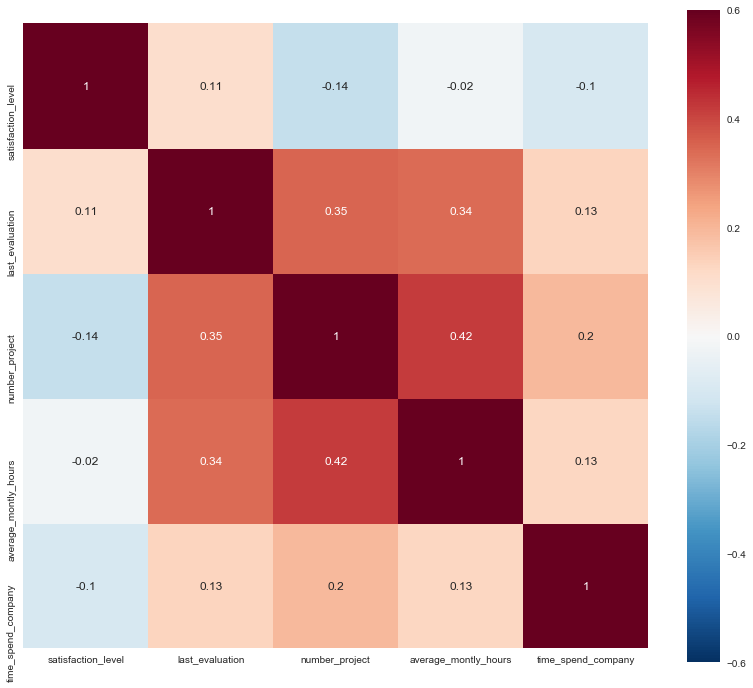

In [16]:
#I need to drop the categorical varaibles as calculating their correlations doesn't make any sense.
datacor = data.drop(['Work_accident', 'promotion_last_5years', 'sales', 'salary', 'left'], axis=1)

plt.figure(figsize=(14,12))
sns.heatmap(datacor.corr(), vmax=0.6, square=True, annot=True)

After we have looked at the variables individually, let's look at them in the context of other variables. First I want to find out whether salaries have anything to do with job categories having different probabilities of leaving. 

What really stands out is that there are proportionally a lot more highly paid positions in management. That could help explain the lower probability in leaving. The other job categories all look fairly similar.

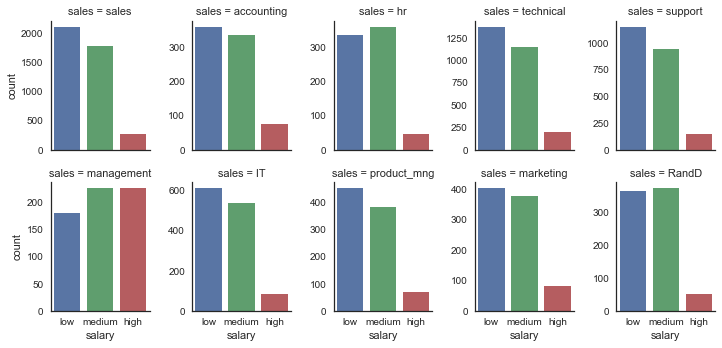

In [17]:
#How do the salaries amongst different job categories look like?
sns.factorplot("salary", col="sales", col_wrap=5,
                   data=data,
                    kind="count", size=2.5, aspect=.8, sharey = False)

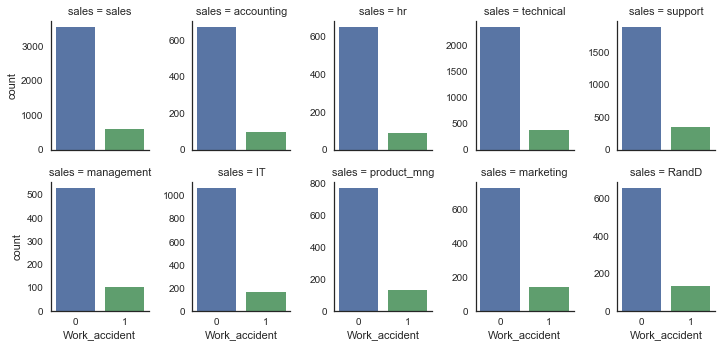

In [18]:
#Where do accidents occur?
sns.factorplot("Work_accident", col="sales", col_wrap=5,
                   data=data,
                    kind="count", size=2.5, aspect=.8, sharey = False)

This equally distributed across all job categories

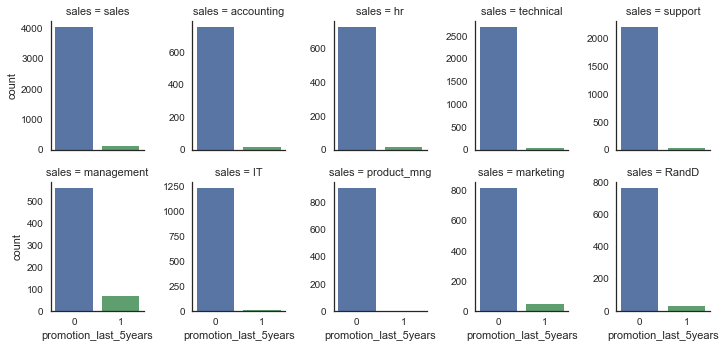

In [19]:
#Who got the promotions?
sns.factorplot("promotion_last_5years", col="sales", col_wrap=5,
                   data=data,
                    kind="count", size=2.5, aspect=.8, sharey = False)

Management (and Marketing + RandD) seem to have more promotions 

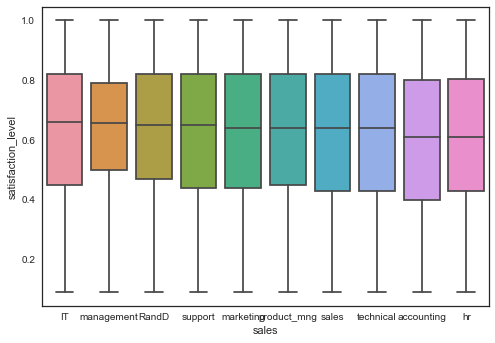

In [20]:
#Who is the most satisfied
median = data.groupby(['sales']).median()
median = pd.DataFrame(median.to_records())
median = median.sort_values(by='satisfaction_level', ascending = False)
median = median['sales']

sns.boxplot('sales', 'satisfaction_level',order=median, data=data)

Satisfaction levels medians are almost the same across all job categories with the exception of accounting and HR.


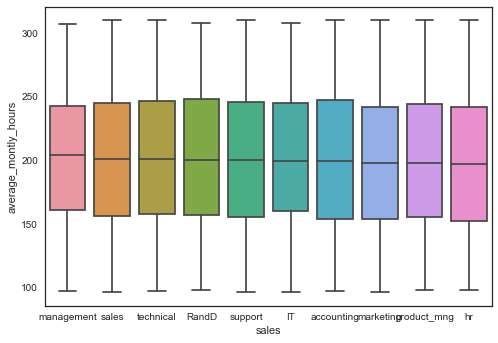

In [21]:
#Who works the longest hours?


median = data.groupby(['sales']).median()
median = pd.DataFrame(median.to_records())
median = median.sort_values(by='average_montly_hours', ascending = False)
median = median['sales']

sns.boxplot('sales', 'average_montly_hours',order=median, data=data)

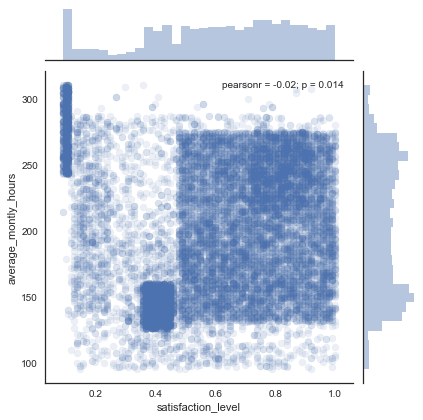

In [22]:
#Is satisfaction level correlated with working hours?

sns.jointplot(x='satisfaction_level', y='average_montly_hours', data=data, alpha=0.1)

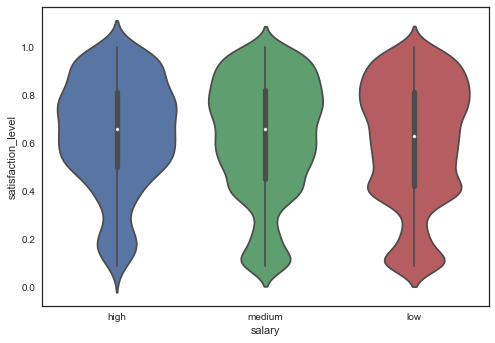

In [23]:
#Satisfaction vs salary

median = data.groupby(['salary']).median()
median = pd.DataFrame(median.to_records())
median = median.sort_values(by='satisfaction_level', ascending = False)
median = median['salary']

sns.violinplot('salary', 'satisfaction_level',order=median, data=data)

Satisfaction levels seem fairly equally distributed across the three salary categories but the mean of *low* is slightly lower than for the other two categories.

# Data Preprocessing

In this section I will one-hot encode **salary** and **sales** and create a training and testing set. 

One-hot encoding means that we create a new column for each type of **sales** - HR, accounting etc. will all have their own column with each cell containing either 1 or 0. Each column is now effectively a dummy variable. If an employee works in HR the corresponding cell will be filled with 1 and otherwise with 0.

One-hot encoding is important for categorical variables that contain values other than 1 and 0. If this isn't done, Python will convert Accounting, HR, Marketing et.c to the numbers 0, 1, 2... which will lead to misleading results.

Splitting the data into training and testing sets allows us to check how well the model performs on unseen data, the testing set.

In [24]:
#Select the variables to be one-hot encoded
one_hot_features = ['salary', 'sales']

# For each categorical column, find the unique number of categories. This tells us how many columns we are adding to the dataset.
longest_str = max(one_hot_features, key=len)
total_num_unique_categorical = 0
for feature in one_hot_features:
    num_unique = len(data[feature].unique())
    print('{col:<{fill_col}} : {num:d} unique categorical values.'.format(col=feature, 
                                                                          fill_col=len(longest_str),
                                                                          num=num_unique))
    total_num_unique_categorical += num_unique
print('{total:d} columns will be added during one-hot encoding.'.format(total=total_num_unique_categorical))

salary : 3 unique categorical values.
sales  : 10 unique categorical values.
13 columns will be added during one-hot encoding.


In [25]:
# Convert categorical variables into dummy/indicator variables (i.e. one-hot encoding).
one_hot_encoded = pd.get_dummies(data[one_hot_features])
one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
salary_high          14999 non-null uint8
salary_low           14999 non-null uint8
salary_medium        14999 non-null uint8
sales_IT             14999 non-null uint8
sales_RandD          14999 non-null uint8
sales_accounting     14999 non-null uint8
sales_hr             14999 non-null uint8
sales_management     14999 non-null uint8
sales_marketing      14999 non-null uint8
sales_product_mng    14999 non-null uint8
sales_sales          14999 non-null uint8
sales_support        14999 non-null uint8
sales_technical      14999 non-null uint8
dtypes: uint8(13)
memory usage: 190.5 KB


In [26]:
#Let's check everything looks like as we were expecting
one_hot_encoded.head()

,salary_high,salary_low,salary_medium,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,1,0,0


In [27]:
#Delete the columns salary and sales...
data = data.drop(['salary', 'sales'], 1)

#...and add the new one-hot encoded variables
data = pd.concat([data, one_hot_encoded], axis=1)
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary_high,salary_low,...,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0.38,0.53,2,157,3,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [28]:
#Split data into training and testing set with 80% of the data going into training
training, testing = train_test_split(data, test_size=0.2, random_state=0)
print("Total sample size = %i; training sample size = %i, testing sample size = %i"\
     %(data.shape[0],training.shape[0],testing.shape[0]))

Total sample size = 14999; training sample size = 11999, testing sample size = 3000


In [29]:
#This creates a list with all column names, which will be used to subset the tables 
cols = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident',
'promotion_last_5years', 'salary_high', 'salary_low', 'salary_medium', 'sales_IT', 'sales_RandD', 'sales_accounting',
'sales_hr', 'sales_management', 'sales_marketing', 'sales_product_mng', 'sales_sales', 'sales_support', 'sales_technical']
tcols = np.append(['left'],cols)

#X are the variables/features that help predict y, which tells us whether an employee left or stayed. This is done for both 
#training and testing
df = training.loc[:,tcols]
X = df.loc[:,cols]
y = np.ravel(df.loc[:,['left']])

df_test = testing.loc[:,tcols]
X_test = df_test.loc[:,cols]
y_test = np.ravel(df_test.loc[:,['left']])

# Data Models

In this section I will first calculate the baseline, which is the accuracy of predicting the most frequent class, which is 76.2% for *stayed*.

I then run several models, which have to beat an accuracy of 76.2 in order to be an improvement to prediction. After I ran all models I collate the accuracy score and present my findings.

In [30]:
#Baseline
print('Left: %i (%.1f percent), Stayed: %i (%.1f percent), Total: %i'\
     %(len(left), 1.*len(left)/len(data)*100.0,\
      len(stayed), 1.*len(stayed)/len(data)*100.0, len(data)))
base_score = len(stayed)/len(data)
print('This is the score to beat:', base_score)

Left: 3571 (23.8 percent), Stayed: 11428 (76.2 percent), Total: 14999
This is the score to beat: 0.7619174611640777


In [31]:
#Logistic Regression
clf_log = LogisticRegression()
clf_log = clf_log.fit(X,y)
score_log = cross_val_score(clf_log, X, y, cv=5).mean()
print(score_log)

0.790399472002


In [32]:
# Perceptron

clf_pctr = Perceptron(
    class_weight='balanced'
    )
clf_pctr = clf_pctr.fit(X,y)
score_pctr = cross_val_score(clf_pctr, X, y, cv=5).mean()
print(score_pctr)

0.647309642907


In [33]:
# KNN

clf_knn = KNeighborsClassifier(
    n_neighbors=10,
    weights='distance'
    )
clf_knn = clf_knn.fit(X,y)
score_knn = cross_val_score(clf_knn, X, y, cv=5).mean()
print(score_knn)

0.953496630541


In [34]:
#SVM

clf_svm = svm.SVC(
    class_weight='balanced'
    )
clf_svm.fit(X, y)
score_svm = cross_val_score(clf_svm, X, y, cv=5).mean()
print(score_svm)

0.931911351952


In [35]:
# Bagging

bagging = BaggingClassifier(
    KNeighborsClassifier(
        n_neighbors=10,
        weights='distance'
        ),
    oob_score=True,
    max_samples=0.5,
    max_features=1.0
    )
clf_bag = bagging.fit(X,y)
score_bag = clf_bag.oob_score_
print(score_bag)

0.947495624635


In [36]:
# Decision Tree

clf_tree = tree.DecisionTreeClassifier(
    #max_depth=3,
    class_weight="balanced",
    min_weight_fraction_leaf=0.01
    )
clf_tree = clf_tree.fit(X,y)
score_tree = cross_val_score(clf_tree, X, y, cv=5).mean()
print(score_tree)

0.958746630541


In [37]:
# Random Forest

clf_rf = RandomForestClassifier(
    n_estimators=1000, 
    max_depth=None, 
    min_samples_split=10 
    #class_weight="balanced", 
    #min_weight_fraction_leaf=0.02 
    )
clf_rf = clf_rf.fit(X,y)
score_rf = cross_val_score(clf_rf, X, y, cv=5).mean()
print(score_rf)

0.979331527025


In [38]:
# Extremely Randomised Trees

clf_ext = ExtraTreesClassifier(
    max_features='auto',
    bootstrap=True,
    oob_score=True,
    n_estimators=1000,
    max_depth=None,
    min_samples_split=10
    #class_weight="balanced",
    #min_weight_fraction_leaf=0.02
    )
clf_ext = clf_ext.fit(X,y)
score_ext = cross_val_score(clf_ext, X, y, cv=5).mean()
print(score_ext)

0.972997846325


In [39]:
# Gradient Boosting

clf_gb = GradientBoostingClassifier(
            #loss='exponential',
            n_estimators=1000,
            learning_rate=0.1,
            max_depth=3,
            subsample=0.5,
            random_state=0).fit(X, y)
clf_gb.fit(X,y)
score_gb = cross_val_score(clf_gb, X, y, cv=5).mean()
print(score_gb)

0.983748610532


In [40]:
# Ada Boost

clf_ada = AdaBoostClassifier(n_estimators=400, learning_rate=0.1)
clf_ada.fit(X,y)
score_ada = cross_val_score(clf_ada, X, y, cv=5).mean()
print(score_ada)

0.956913401417


In [41]:
#eXtreme Gradient Boosting

clf_xgb = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=500,
    subsample=0.5,
    learning_rate=0.1
    )
clf_xgb.fit(X,y)
score_xgb = cross_val_score(clf_xgb, X, y, cv=5).mean()
print(score_xgb)

0.975081249132


The results are in and tabulated below and shown graphically. We can boost prediction accuracy from 76.2% to 98% using Gradient Boosting or Random Forest, which is a significant increase. This is the cross-validation score using the training set only. In the next section I will test accuracy using the trained models on the unseen testing set.

In [42]:
models = pd.DataFrame({
        'Model' : ['Baseline', 'Logistic Regression', 'Perceptron', 'KNN', 'SVM', 'Bagging', 'Decision Tree',
                   'Random Forest', 'Extra Tree', 'Gradient Boosting', 'ADA Boosting', 'XGBoost'],
        'Score' : [base_score, score_log, score_pctr, score_knn, score_svm, score_bag, score_tree, score_rf, score_ext, score_gb, 
                    score_ada, score_xgb]  
})

models = models.sort_values(by='Score', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

models

,Model,Score
9,Gradient Boosting,0.983749
7,Random Forest,0.979332
11,XGBoost,0.975081
8,Extra Tree,0.972998
6,Decision Tree,0.958747
10,ADA Boosting,0.956913
3,KNN,0.953497
5,Bagging,0.947496
4,SVM,0.931911
1,Logistic Regression,0.790399


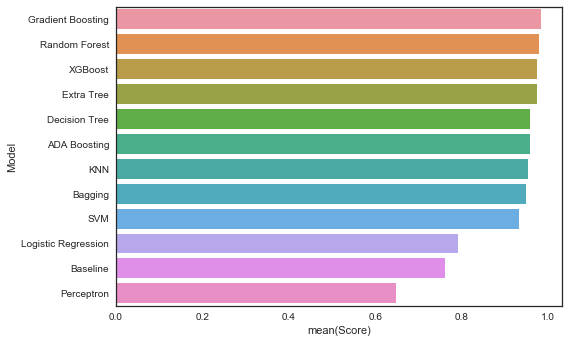

In [43]:
sns.barplot(y=models.Model, x=models.Score)

# Model Validation on test set

We get similar scores using the test set

In [44]:
score_log_test = clf_log.score(X_test, y_test)
score_pctr_test = clf_pctr.score(X_test, y_test)
score_knn_test = clf_knn.score(X_test, y_test)
score_svm_test = clf_svm.score(X_test, y_test)
score_bag_test = clf_bag.score(X_test, y_test)
score_tree_test = clf_tree.score(X_test, y_test)
score_rf_test = clf_rf.score(X_test, y_test)
score_ext_test = clf_ext.score(X_test, y_test)
score_gb_test = clf_gb.score(X_test, y_test)
score_ada_test = clf_ada.score(X_test, y_test)
score_xgb_test = clf_xgb.score(X_test, y_test)

In [45]:
models_test = pd.DataFrame({
        'Model' : ['Baseline', 'Logistic Regression', 'Perceptron', 'KNN', 'SVM', 'Bagging', 'Decision Tree',
                   'Random Forest', 'Extra Tree', 'Gradient Boosting', 'ADA Boosting', 'XGBoost'],
        'Score' : [base_score, score_log_test, score_pctr_test, score_knn_test, score_svm_test, score_bag_test, score_tree_test,
                   score_rf_test, score_ext_test, score_gb_test, 
                    score_ada_test, score_xgb_test]  
})

models_test = models_test.sort_values(by='Score', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

models_test

,Model,Score
9,Gradient Boosting,0.986667
7,Random Forest,0.978667
11,XGBoost,0.978333
8,Extra Tree,0.972667
10,ADA Boosting,0.964000
3,KNN,0.961667
5,Bagging,0.954667
6,Decision Tree,0.952667
4,SVM,0.944667
1,Logistic Regression,0.786333


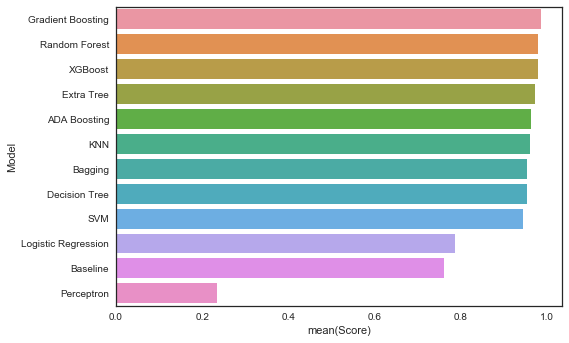

In [46]:
sns.barplot(y=models_test.Model, x=models_test.Score)

# Feature Importance using Random Forest as Example

The models are doing a great job at predicting who is going to leave or stay but they are a bit of a black box. So, what factors are influencing the decision of an employee to leave. This is useful information for the company so that they can tackle their turn-over and focus on the right factors.

As an example, I will investigate what factors were the most important in predicting the outcome in Random Forest.  

In [47]:
importance = pd.DataFrame(list(zip(X.columns, np.transpose(clf_rf.feature_importances_))) \
            ).sort_values(1, ascending=False)
importance

,0,1
0,satisfaction_level,0.312920
4,time_spend_company,0.188446
2,number_project,0.185968
3,average_montly_hours,0.151333
1,last_evaluation,0.120541
5,Work_accident,0.010145
8,salary_low,0.006624
7,salary_high,0.005447
9,salary_medium,0.002543
19,sales_technical,0.002444


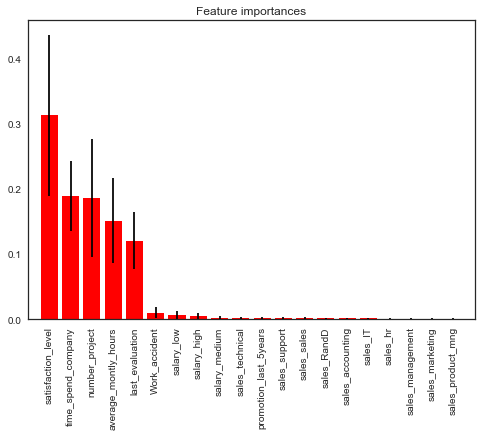

In [48]:
importances = clf_rf.feature_importances_

std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],  
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]),X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()